In [ ]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the dataset
df=pd.read_csv('StudentsPerformance.csv')


In [6]:
df.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [8]:
# Dataframe summary

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summ['Missing'] = df.isna().sum()
    summ['Missing%'] = (df.isna().sum())/len(df)
    summ['Dups'] = df.duplicated().sum()
    summ['Uniques'] = df.nunique().values
    summ['Count'] = df.count().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['Min'] = desc['min'].values
    summ['Max'] = desc['max'].values
    summ['Average'] = desc['mean'].values
    summ['Standard Deviation'] = desc['std'].values
    
    display(summ)

summary(df)

data shape: (1000, 8)


,Data Type,Missing,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation
gender,object,0,0.0,0,2,1000,NaN,NaN,NaN,NaN
race/ethnicity,object,0,0.0,0,5,1000,NaN,NaN,NaN,NaN
parental level of education,object,0,0.0,0,6,1000,NaN,NaN,NaN,NaN
lunch,object,0,0.0,0,2,1000,NaN,NaN,NaN,NaN
test preparation course,object,0,0.0,0,2,1000,NaN,NaN,NaN,NaN
math score,int64,0,0.0,0,81,1000,0.0,100.0,66.089,15.16308
reading score,int64,0,0.0,0,72,1000,17.0,100.0,69.169,14.600192
writing score,int64,0,0.0,0,77,1000,10.0,100.0,68.054,15.195657


In [9]:
df.isnull().sum()


gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [10]:
df[df.duplicated()]


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score


In [12]:
# Drop the Patient ID column
# df.drop('Patient ID', axis=1, inplace=True)

In [24]:
df1=df.drop(columns=['race/ethnicity','parental level of education', 'lunch', 'test preparation course', 'gender'], axis=1)
# print(type(df1))
if df1 is not None:
   df1 = df1.corr()
   print(df1)
  

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


<Axes: >

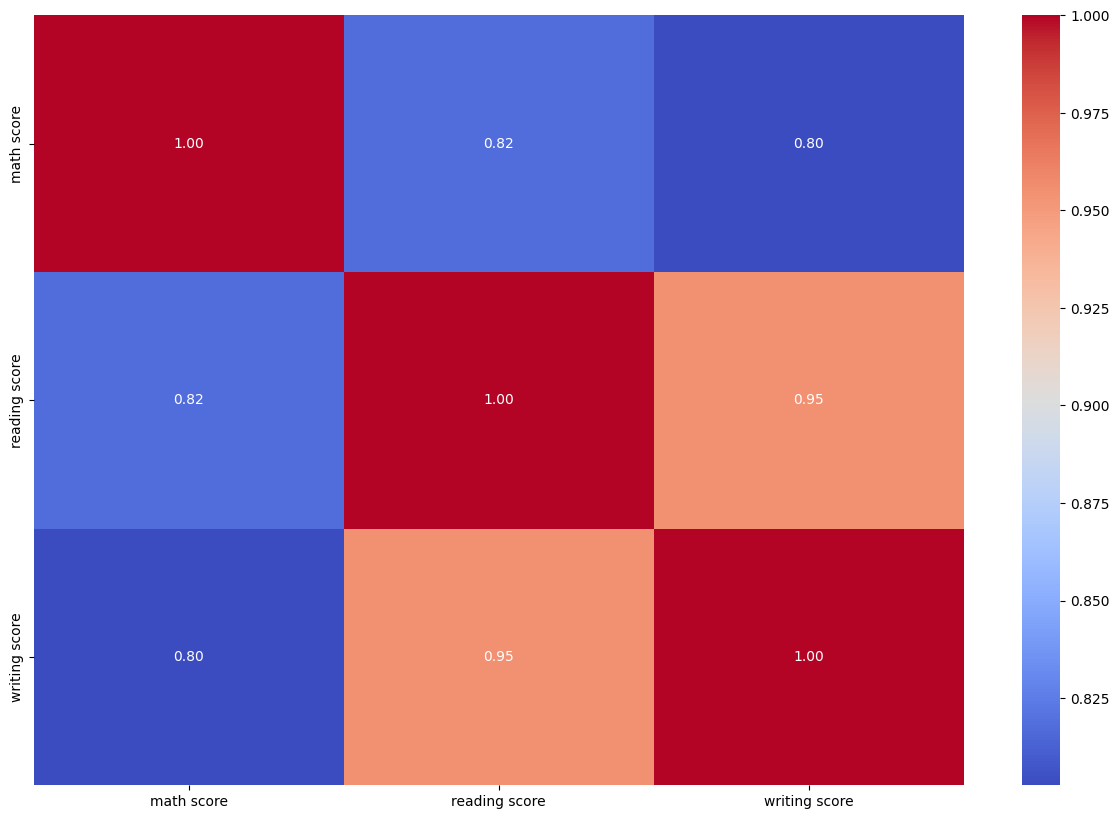

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(df1, annot=True, cmap='coolwarm', fmt=".2f")

In [27]:
def high_correlation_retriever(dataset, treshold):
    # col_corr=set()
    col_corr=[]
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])> treshold:
                col_name= corr_matrix.columns[i]
                # col_corr.add(col_name)
                col_corr.append(col_name)
    return col_corr

high_correlation_retriever(df.drop(columns=['race/ethnicity','parental level of education', 'lunch', 'test preparation course', 'gender'], axis=1), 0.80)

['reading score', 'writing score', 'writing score']

In [29]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [30]:
# Séparation of features by type(stay in the part of feature encoding when we know that don't have to handle outliers)
numerical_cols=[col for col in df.columns if df[col].dtype != "O"]

print(f"There are {len(numerical_cols)} numerical features")
categorical_cols=[col for col in df.columns if df[col].dtype == "O"]

print(f"There are {len(categorical_cols)} categorical features")

discrete_cols=[col for col in numerical_cols if len(df[col].unique()) <=10 ]
print(f"There are {len(discrete_cols)} discrete features")

continuous_cols=[col for col in numerical_cols if df[col].nunique() >10 ]
print(f"There are {len(continuous_cols)} continuous features")

There are 3 numerical features
There are 5 categorical features
There are 0 discrete features
There are 3 continuous features


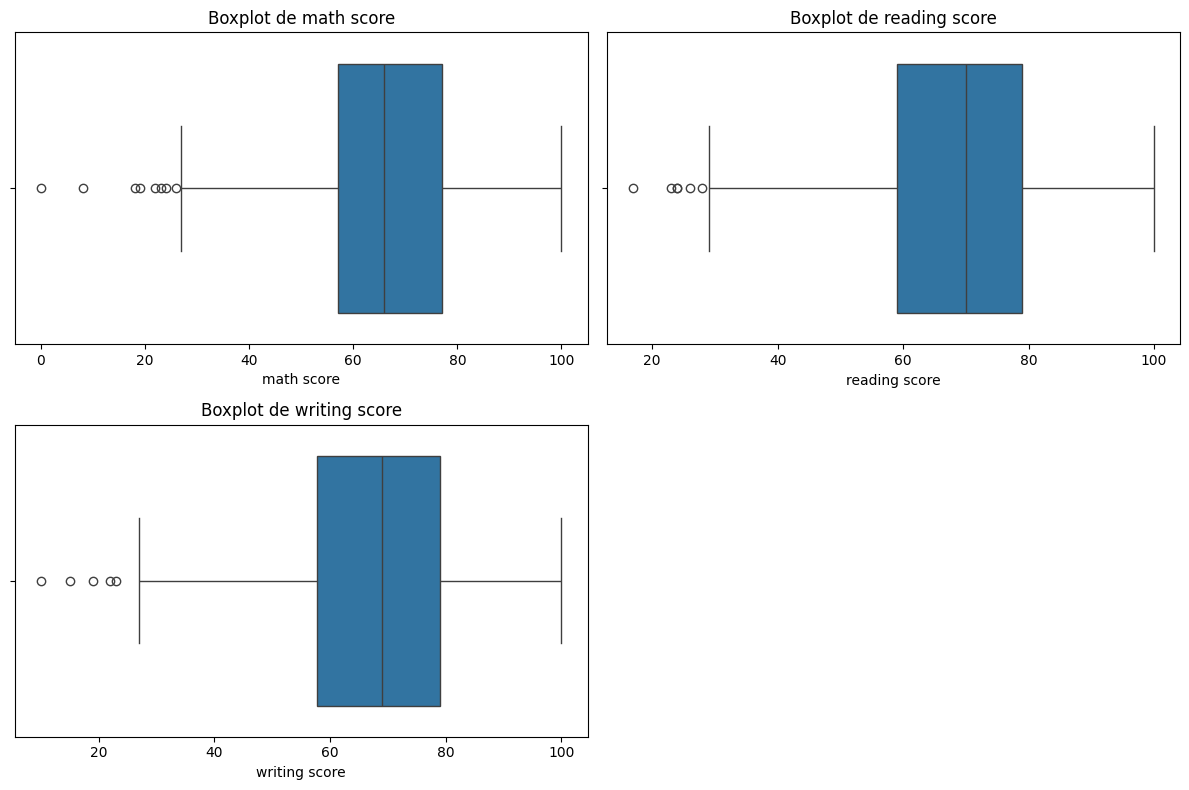

In [31]:
# Handling Outliers
# After testing with numerical_cols I see that it is better with continuous_cols
plt.figure(figsize=(12, 8))
for i,feature in enumerate(continuous_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot de {feature}')

plt.tight_layout()
plt.show()

In [32]:
# To handle them we should drop the rows that countains values more or less than lower and higher fence
for i in range (0, len(continuous_cols)):
     minimum, Q1, median, Q3, maximum = np.quantile(df[continuous_cols[i]], [0, 0.25, 0.5, 0.75, 1])
     IQR =Q1-Q3
     lower_fence=Q1-1.5*IQR
     higher_fence=Q1+1.5*IQR
     print(f"""{continuous_cols[i]} :
               Minimum: {minimum}
               Q1: {Q1}
               Median: {median}
               Q3: {Q3}
               Maximum: {maximum}
               Lower_fence: {lower_fence}
               Higher_fence: {higher_fence}""")
     print('-'*30)

math score :
               Minimum: 0.0
               Q1: 57.0
               Median: 66.0
               Q3: 77.0
               Maximum: 100.0
               Lower_fence: 87.0
               Higher_fence: 27.0
------------------------------
reading score :
               Minimum: 17.0
               Q1: 59.0
               Median: 70.0
               Q3: 79.0
               Maximum: 100.0
               Lower_fence: 89.0
               Higher_fence: 29.0
------------------------------
writing score :
               Minimum: 10.0
               Q1: 57.75
               Median: 69.0
               Q3: 79.0
               Maximum: 100.0
               Lower_fence: 89.625
               Higher_fence: 25.875
------------------------------


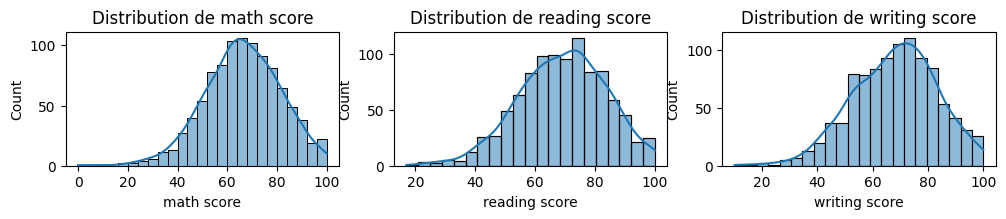

In [33]:
# View of Features Distribution:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(continuous_cols):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution de {feature}')
    

In [36]:
df.to_csv("data.csv", sep=";", index=False)
